In [1]:
import pandas as pd
import torch
from torch.utils import data
import numpy as np
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision 
import torchvision.transforms.functional as func
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

In [3]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

In [4]:
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
    
        self.root = root
        # the type is numpy.ndarray
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):

        # Step 1.Get the image path from 'self.img_name' and load it
        path = self.root + self.img_name[index] + '.jpeg' 
        img  = Image.open(path).convert('RGB')
        
        # Step 2.Get the ground truth label
        label = self.label[index]
        
        transform = transforms.Compose([
#         transforms.ToPILImage(),
        transforms.ToTensor()])
#         transforms.RandomCrop((300,300))])
        
        # Step 3.Transform the .jpeg rgb images
        img = transform(img)
        img = torch.unsqueeze(img, 0)
        label = torch.from_numpy(np.array(label))
#         img = transforms.Normalize(img,(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         img = torchvision.transforms.ToPILImage(img)
#         img = torchvision.transforms.ToTensor()(img)

        return img, label

In [5]:
reti_loader = RetinopathyLoader("/home/wang/Desktop/Auberon/LAB3/data/", "train")

> Found 28099 images...


In [6]:
len(reti_loader)

28099

In [7]:
reti_loader[0][0].size()

torch.Size([1, 3, 512, 512])

In [8]:
a = data.DataLoader(reti_loader)

In [9]:
type(a.dataset)

__main__.RetinopathyLoader

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
#         self.bn1 = nn.BatchNorm2d(64)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        # maxpool 處理
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(in_features=51200, out_features=1000, bias=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # maxpool處理
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
        out = F.avg_pool2d(out, kernel_size=7, stride=1, padding=0)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ResNet架構來源 https://zhuanlan.zhihu.com/p/31852747
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


def test():
    net = ResNet18()
    y = net(reti_loader[0][0])
    print(y.size())
    print(y)

# test()

# ResNet18 

In [12]:
# 呼叫ResNet18
net = ResNet18()
# GPU運算
net.to(device)
# loss function
loss_fun = F.cross_entropy
# optimizer 
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)
# 起始running_loss
running_loss = 0.0

# 計算ACC
true_ans = 0.0
false_ans = 0.0

# Number of train data
num_train = 28099

In [13]:
def ResNet18_train(n):
    running_loss = 0.0
    true_ans = 0.0
    false_ans = 0.0
    for i in range(n):
        inputs = reti_loader[i][0].to(device)
        labels = reti_loader[i][1].to(device)
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        labels = torch.unsqueeze(labels, 0)
        output = loss_fun(outputs, labels)
        output.backward()
        output

        optimizer.step()

        running_loss =+ output.cpu().data.numpy()
        net.eval()

        result = output

        ground_true = labels.cpu().detach().numpy()[0]
        pred_y = np.round(result.cpu().detach().numpy())

        if ground_true == pred_y:
            true_ans = true_ans + 1
        else:
            false_ans = false_ans + 1
    return true_ans, false_ans
    

# 沒有pretrain data

In [15]:
# 運算
epoch_list = []
acc_list = []

for epoch in range(10):
    epoch_list.append(epoch)
    print ("This is epoch "+ str(epoch+1))
    
    result = ResNet18_train(num_train)
    ACC = (result[0]/(result[0]+result[1]))
    
    acc_list.append(ACC)
    print ("The ACC is : "+str(ACC))

This is epoch 1
The ACC is : 0.619
This is epoch 2
The ACC is : 0.673
This is epoch 3
The ACC is : 0.702
This is epoch 4
The ACC is : 0.723
This is epoch 5
The ACC is : 0.734
This is epoch 6
The ACC is : 0.743
This is epoch 7
The ACC is : 0.758
This is epoch 8
The ACC is : 0.768
This is epoch 9
The ACC is : 0.772
This is epoch 10
The ACC is : 0.782


In [17]:
# 運算
epoch_list = []
acc_list = []

for epoch in range(10):
    epoch_list.append(epoch)
    print ("This is epoch "+ str(epoch+1))
    
    result = ResNet18_train(num_train)
    ACC = (result[0]/(result[0]+result[1]))
    
    acc_list.append(ACC)
    print ("The ACC is : "+str(ACC))

This is epoch 1
The ACC is : 0.817
This is epoch 2
The ACC is : 0.819
This is epoch 3
The ACC is : 0.82
This is epoch 4
The ACC is : 0.821
This is epoch 5
The ACC is : 0.822
This is epoch 6
The ACC is : 0.819
This is epoch 7
The ACC is : 0.82
This is epoch 8
The ACC is : 0.821
This is epoch 9
The ACC is : 0.822
This is epoch 10
The ACC is : 0.821


In [23]:
torch.save(net, 'ResNet18_model.pkl')

In [27]:
net = torch.load('ResNet18_model.pkl')

In [178]:
# reti_loader[0][0]
net = ResNet18()
# model = net(reti_loader[0][0])

In [213]:
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [214]:
loss_fun = F.cross_entropy
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

In [215]:
running_loss = 0.0

In [221]:
inputs = reti_loader[0][0].to(device)
labels = reti_loader[0][1].to(device)

In [222]:
inputs, labels = Variable(inputs), Variable(labels)

In [223]:
optimizer.zero_grad()

In [225]:
outputs = net(inputs)

In [226]:
labels = torch.unsqueeze(labels, 0)

In [227]:
output = loss_fun(outputs, labels)

In [228]:
output.backward()

In [229]:
output

tensor(5.5557, device='cuda:0', grad_fn=<NllLossBackward>)

In [230]:
optimizer.step()

In [260]:
running_loss = running_loss + output.data

In [231]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

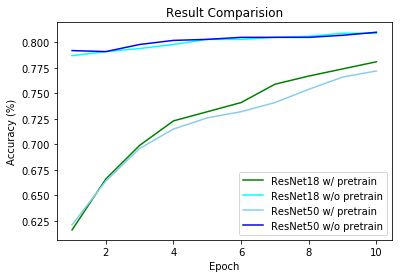

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.title('Result Comparision')
plt.plot(epoch_res, acc_res18_pre, color='green', label='ResNet18 w/ pretrain')
plt.plot(epoch_res, acc_res18, color='cyan', label='ResNet18 w/o pretrain')
plt.plot(epoch_res, acc_res50_pre,  color='skyblue', label='ResNet50 w/ pretrain')
plt.plot(epoch_res, acc_res50,  color='blue', label='ResNet50 w/o pretrain')

plt.legend() 

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [1]:
epoch_res = [1,2,3,
            4,5,6,
            7,8,9,
            10]

In [7]:
acc_res18_pre = [0.616,0.666,0.699,
                0.723,0.732,0.741,0.759,0.767,0.774,0.781]

In [ ]:
# no pretrain Res18
This is epoch 1
The ACC is : 0.616
This is epoch 2
The ACC is : 0.666
This is epoch 3
The ACC is : 0.699
This is epoch 4
The ACC is : 0.723
This is epoch 5
The ACC is : 0.732
This is epoch 6
The ACC is : 0.741
This is epoch 7
The ACC is : 0.759
This is epoch 8
The ACC is : 0.767
This is epoch 9
The ACC is : 0.774
This is epoch 10
The ACC is : 0.781

In [3]:
acc_res18 = [0.787,0.791,0.794,
            0.798,0.803,0.803,0.805,0.806,0.809,0.809]

In [ ]:
# pretrain Res18
This is epoch 1
The ACC is : 0.787
This is epoch 2
The ACC is : 0.791
This is epoch 3
The ACC is : 0.794
This is epoch 4
The ACC is : 0.798
This is epoch 5
The ACC is : 0.803
This is epoch 6
The ACC is : 0.803
This is epoch 7
The ACC is : 0.805
This is epoch 8
The ACC is : 0.806
This is epoch 9
The ACC is : 0.809
This is epoch 10
The ACC is : 0.809

In [12]:
acc_res50_pre = [0.621,0.664,0.696,
                 0.715,0.726,0.732,
                 0.741,0.754,0.766,
                 0.772]

In [ ]:
# no pretrain Res50
This is epoch 1
The ACC is : 0.621
This is epoch 2
The ACC is : 0.664
This is epoch 3
The ACC is : 0.696
This is epoch 4
The ACC is : 0.715
This is epoch 5
The ACC is : 0.726
This is epoch 6
The ACC is : 0.732
This is epoch 7
The ACC is : 0.741
This is epoch 8
The ACC is : 0.754
This is epoch 9
The ACC is : 0.766
This is epoch 10
The ACC is : 0.772

In [10]:
acc_res50 = [0.792,0.791,0.798
             ,0.802,0.803,0.805,
             0.805,0.805,0.807,
             0.81]

In [ ]:
# pretrain Res50
This is epoch 1
The ACC is : 0.792
This is epoch 2
The ACC is : 0.791
This is epoch 3
The ACC is : 0.798
This is epoch 4
The ACC is : 0.802
This is epoch 5
The ACC is : 0.803
This is epoch 6
The ACC is : 0.805
This is epoch 7
The ACC is : 0.805
This is epoch 8
The ACC is : 0.805
This is epoch 9
The ACC is : 0.807
This is epoch 10
The ACC is : 0.81
